Directory: 
run the first cell to select the working directory.
run the second cell to select the frog data
the third cell zooms in on the frog data. the user must select the appropriate zooming size
the last cell saves the post processed frog data into 3 seperated files:
    post processed data without header.csv ;
    post processed data with header.csv ;
    header.txt

Then use Weinacht's group's frog retrieval software to perform frog retrieval using the csv files. 

In [ ]:
import pandas as pd
import easygui as eg
import numpy as np
from numpy import sum , vstack, zeros, array, asarray, linspace, arange, append, intp
from numba import njit, jit
from tqdm import trange
import easygui as eg
import h5py
import numpy as np
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import scatter, ylim, xlim, xlabel, ylabel
import glob, os
import statistics
from statistics import mode
import pathlib
import scipy
from scipy.optimize import curve_fit
import scipy.stats
from scipy.stats import expon
from time import time
import seaborn as sns
# import gaussfitter2


#change file directory - run this only once
currdir = os.getcwd()
subpath = eg.diropenbox('Open me', 'this one', 'D://Google Drive//')
print("The data is being read from", subpath)
os.chdir(subpath)


data opened from:	D:\Google Drive\Allison's Lab\DATA\Dispersive Wave Related\generated dispersive wave using haphit filter\menlo port D- haphit 1565-60\haphit-1550-60 dispersive wave gen\63cm long fiber before hnlf.csv


<AxesSubplot: >

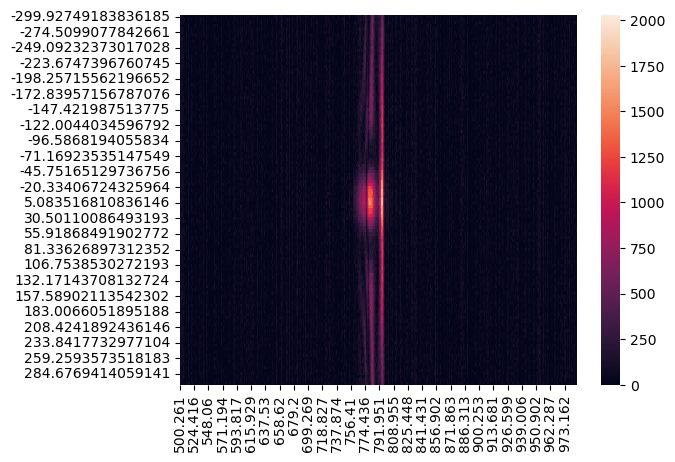

In [62]:
# prelimiary data reading and processing
# 1. read data as csv
# 2. use zoom in on wavelength to zoom in on the frog spectrum so that most of the data are useful
# the 


#change root directory of the python program
currdir = os.getcwd()
# subpath = eg.diropenbox('Open me', 'this one', 'C://Users//Lab3//Desktop//Sonali//')
filepath = eg.fileopenbox('Open me', 'this one', subpath)
# print("The data is being read from", subpath)
# os.chdir(subpath)

#import data from csv
FROGRaw = pd.read_csv(filepath,index_col=0,dtype=np.float64) # read as csv with index being the first column(delay)
FROGRaw.columns = FROGRaw.columns.astype(float) #the wavelength used to be in string, change it to float!
FROGspectrum = FROGRaw.sum(axis=0) #sum over the horizontal axis to get the whole spectrum



# Plot original FROG Trace
print('data opened from:\t'+filepath)
sns.heatmap(data=FROGRaw)



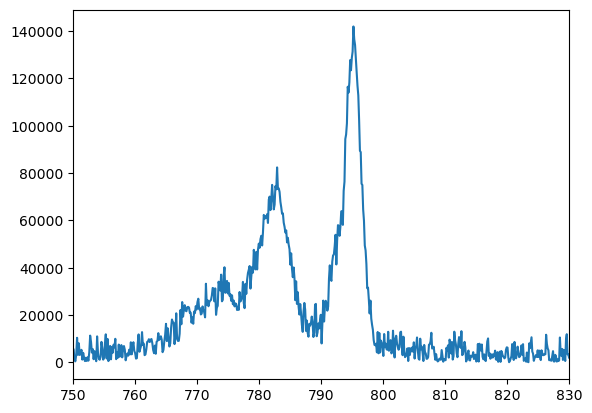

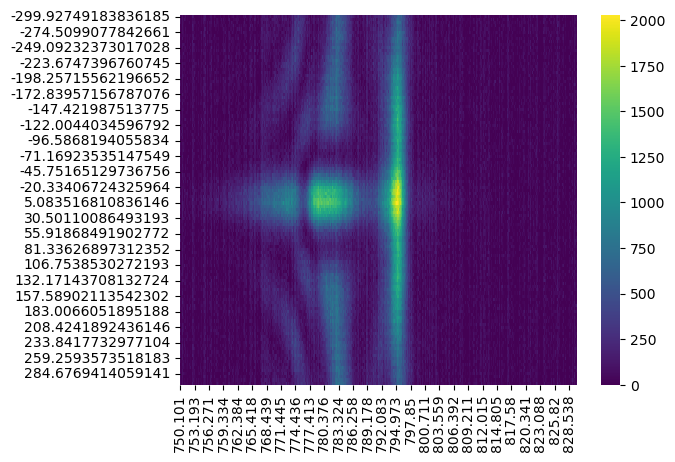

In [63]:
#shifts the FROG spectrum by -4.893nm because the OSA is not measuring spectrum correctly - tested by the HeNe
def ShiftFrogby5(OriginalFrog):
    ShiftedFROG = OriginalFrog-4.893
    return ShiftedFROG




#zoom in on wavelength
lowWv = 750
highWv = 830

#zoom in on time
lowT = -2200
highT = 2200


# Plot Spectrum of the origianl FROG data --> to find the correct range to truncate the data
fig, axe = plt.subplots()
p = sns.lineplot(FROGspectrum,ax=axe)
p.set(xlim = (lowWv,highWv)) #change this to zoom in or out on the wavelength axis.
plt.show()


# Plot truncated data
FROGTrunc = FROGRaw.truncate(before=lowWv,after = highWv,axis="columns") 
FROGTrunc = FROGTrunc.truncate(before=lowT,after = highT,axis="rows")
FROGspectrumTrunc = FROGTrunc.sum(axis=0) #truncated spectrum
sns.heatmap(data=FROGTrunc,cmap = "viridis")


# truncated FROG intensity, delayFs, wavelengthnm
FROGIntensity = FROGTrunc.to_numpy()  #intensity data as 2d numpy array float
FROGdelayFs = FROGTrunc.index.to_numpy()  #delayFs from index to 1d np float
FROGwaveLengthnm = FROGTrunc.columns.to_numpy()  #wavelength as FROGTrunc.columns 1d np to float
FROGwaveLengthnm = ShiftFrogby5(FROGwaveLengthnm)

63cm long fiber before hnlf
Necessary stuff to add before the data(must be in this order), or to be filled in the software
119 	 # number of delay points
606 	 # number of wavelength points
5.08351681081183 	 #delay increment in fs
0.13999999999998636 	 #wavelength increment in nm
785.103 	 #wavelength of the center pixel


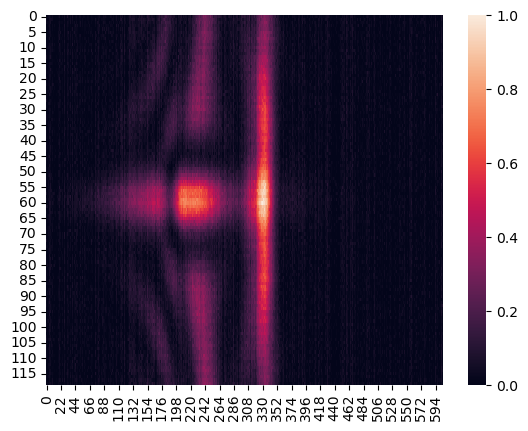

In [64]:
#saving files for data processing using Frog3.exe from Weinacht's group
FROGIntensityNmed = FROGIntensity/FROGIntensity.max()  # normalized to 1



# create a new folder that's identical to the filename to save the post processed frog data and 
filename = os.path.basename(filepath)[:-4] # basename outputs the file name. ex: 4_1.2A 35cm pm1550.csv. basename[:-4] gives 4_1.2A 35cm pm1550
print(filename)
if not os.path.exists(filename):
    os.makedirs(filename)

sns.heatmap(data=FROGIntensityNmed)
    

numDelay = len(FROGdelayFs)
numWvlngth = len(FROGwaveLengthnm)

DelayIncre = FROGdelayFs[1]-FROGdelayFs[0]
WvLngthIncre = FROGwaveLengthnm[1]-FROGwaveLengthnm[0]
WvLngthCenter = (FROGwaveLengthnm[0]+FROGwaveLengthnm[-1])/2

print('Necessary stuff to add before the data(must be in this order), or to be filled in the software')
print(len(FROGdelayFs),'\t # number of delay points')
print(len(FROGwaveLengthnm),'\t # number of wavelength points')
print(FROGdelayFs[1]-FROGdelayFs[0],'\t #delay increment in fs')
print(FROGwaveLengthnm[1]-FROGwaveLengthnm[0], '\t #wavelength increment in nm')
print((FROGwaveLengthnm[0]+FROGwaveLengthnm[-1])/2, '\t #wavelength of the center pixel')

np.savetxt(filename+"\\PostProcessed FROG Trace.csv", FROGIntensityNmed,delimiter='\t')




# create a header string
header = str(numDelay)+'\n' + str(numWvlngth) + '\n' + str(DelayIncre) + '\n' + str(WvLngthIncre) + '\n' + str(WvLngthCenter)


# save the array to a text file with the header
np.savetxt(filename+"\\PostProcessed FROG Trace_with header.csv", FROGIntensityNmed,delimiter='\t',header = header, comments= '')


# save the parameters into a info txt file
info = 'Necessary stuff to add before the data(must be in this order), or to be filled in the software' + '\n' + str(numDelay) + '\t\t\t number of delay points' + '\n' + str(numWvlngth) + '\t\t\t number of wavelength points' + '\n' + str(DelayIncre) + '\t\t\t delay increment in fs' + '\n' + str(WvLngthIncre) + '\t\t\t wavelength increment in nm' + '\n' + str(WvLngthCenter) + '\t\t\t wavelength of the center pixel'
np.savetxt(filename+"\\PostProcessed FROG parameter.txt", np.array([]),delimiter='\t',header = info, comments= '')


In [36]:
# Turn CSV spectrum file into txt that are whitespace sperated 
def OpenCSVFiles():
    directory = eg.diropenbox('Open me', 'this one', 'D://Google Drive//')
    filenames = os.listdir(directory)
    print('changing the root directory to:\t'+directory)
    print('filenames are:\t',filenames)
    return directory, filenames
directory, filenames = OpenCSVFiles()

# loop through all files in the directory

dfs = []
for filename in filenames:
    # check if file ends with .csv or .txt
    if filename.endswith('.csv') or filename.endswith('.CSV'):
        # read the data from the file into a pandas dataframe
        # print('reading:',os.path.join(directory, filename))
        df = pd.read_csv(os.path.join(directory, filename))
        dfs.append(df)
    if filename.endswith('.xls') or filename.endswith('.xlsx'):
        df = pd.read_excel(os.path.join(directory, filename), sheet_name = 1)
        dfs.append(df)

for i in range(len(dfs)):
    df_new = dfs[i].iloc[:, :2] # select first two column
    df_new_numeric = df_new.applymap(lambda x: pd.to_numeric(x, errors='coerce')).dropna() # select only numerical rows
    WaveLength = np.array(df_new_numeric.iloc[:,0].values, dtype = 'float64')
    SpectrumIntensity = np.array(df_new_numeric.iloc[:,1].values, dtype = 'float64')
    plt.plot(WaveLength,SpectrumIntensity) #plot the spectrum
    doubleColumnSpectrumData = np.transpose(np.array([WaveLength,SpectrumIntensity])) #making spectrum into two column data
    np.savetxt(directory+'\\'+filenames[0][:-4]+".txt", doubleColumnSpectrumData,delimiter=' ') #save into a whitespace-spaced txt file

TypeError: can only concatenate str (not "NoneType") to str

(1520.0, 1600.0)

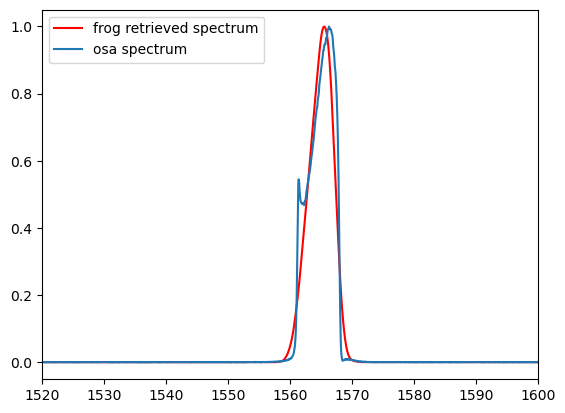

In [4]:
#open FROG GENERATED speck.txt to compare with the spectrum from osa

filepath = eg.fileopenbox('Open me', 'select the FROG retrieved spectrum speck.dat', subpath)


speck = np.loadtxt(os.path.join(filepath))
FROGGenWv = speck[:, 0]
FROGGenInt = speck[:, 1]
plt.plot(FROGGenWv,FROGGenInt,'r',label='frog retrieved spectrum')
plt.plot(WaveLength,SpectrumIntensity/max(SpectrumIntensity),label='osa spectrum')
plt.legend()
plt.xlim(1520,1600)

data is being read from: D:\Google Drive\Allison's Lab\DATA\BenchMarking FROG setup\menlo haphit 1meter of pm1550 0.15mW power\menlo haphit 1meter of pm1550-21m pm1550 _0.15mW power~100uw\Ek.dat


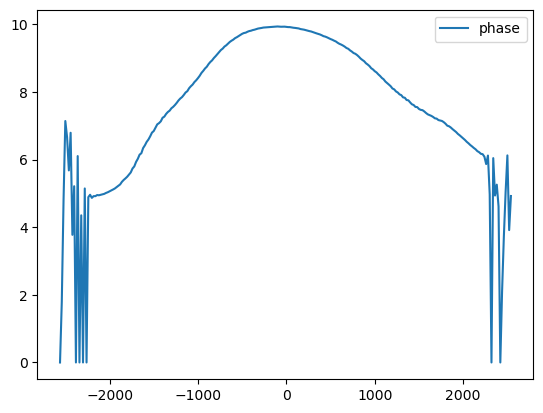

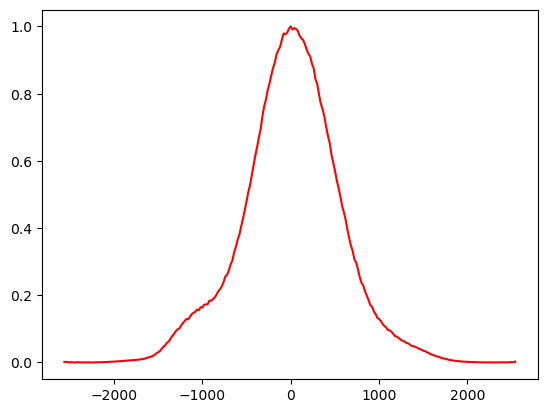

In [48]:
#open FROG GENERATED speck.txt to compare with the spectrum from osa

filepath = eg.fileopenbox('Open me', 'select the FROG retrieved spectrum speck.dat', subpath)
print('data is being read from:',filepath)

Ek = np.loadtxt(os.path.join(filepath))
FROGGenDelay = Ek[:, 0]
FROGGenInt = Ek[:, 1]
FROGGenPhase = Ek[:,2]
# plt.plot(FROGGenDelay,FROGGenInt,'r',label='frog retrieved spectrum')
plt.plot(FROGGenDelay,FROGGenPhase,label='phase')
plt.legend()
# plt.xlim(1520,1600)
plt.show()
plt.figure()
plt.plot(FROGGenDelay,FROGGenInt,'r',label='frog retrieved spectrum')
plt.show()

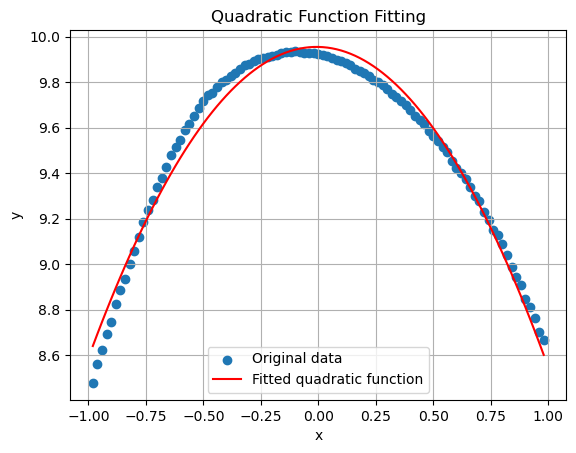

[-1.3866602  -0.0198813   9.95484603]
bs = a*2: -2.773320391900177
the intensity FWHM is: 1040.85 fs


In [49]:
# calculate intensity FWHM and fit the phase with a quadratic function to calculate bs.
# Fit a quadratic function to the dataset

import numpy as np

def calculate_fwhm(x, y):
    # Find the maximum value and its index
    max_index = np.argmax(y)
    max_value = y[max_index]
    
    # Calculate half maximum value
    half_max = max_value / 2
    
    # Find the indices where the data crosses half maximum
    left_index = np.argmin(np.abs(y[:max_index] - half_max))
    right_index = np.argmin(np.abs(y[max_index:] - half_max)) + max_index
    
    # Calculate the FWHM
    fwhm = x[right_index] - x[left_index]
    
    return fwhm





x = FROGGenDelay[((FROGGenDelay>-1000)&(FROGGenDelay<1000))]
y = FROGGenPhase[((FROGGenDelay>-1000)&(FROGGenDelay<1000))]
x = x/1000
coeffs = np.polyfit(x, y, 2)  # Fit a quadratic polynomial (degree 2)
a, b, c = coeffs  # Extract coefficients

# Create the fitted quadratic function
fitted_y = a * x**2 + b * x + c

# Plot the original dataset and the fitted quadratic function
plt.scatter(x, y, label='Original data')
plt.plot(x, fitted_y, color='red', label='Fitted quadratic function')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Quadratic Function Fitting')
plt.grid(True)
plt.show()

print(coeffs)
print('bs = a*2:',a*2)


intensityFWHM= calculate_fwhm(FROGGenDelay,FROGGenInt)
print('the intensity FWHM is:', intensityFWHM, 'fs')